In [1]:
require("igraph")
require("GIGrvg")
require("gtools")

setwd("~/git/Bayesian_forest_clustering/")

load("time_series_fmri_std.RDa")

S <- length(timeseries_fmri_std)
S


Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: GIGrvg

Loading required package: gtools


Attaching package: ‘gtools’


The following object is masked from ‘package:igraph’:

    permute




[1] 166

In [2]:
load("fmri_labels.RDa")

In [3]:
labels0<- do.call("c",label_list)

In [4]:
ord_idx<- order(labels0)

In [5]:
# # double check to make sure group id matches with subject id

# filename<- list.files("../../orange/AAL_fmri/")

# require("stringr")

# list2<- lapply(labels_table$V1, function(x) str_split(x,"/")[[1]][2])

# for(s in 1:S){
#     if(list2[[s]] !=filename[s]){
#     print(s)
#     }
# }


In [6]:
labels <- labels0[ord_idx]

In [7]:
source("forest_class.R")


In [8]:
S

[1] 166

In [9]:
#create a list of forest objects

forest_objs = list()

y_mat<- numeric()

for(s in 1:S){
  forest_objs[[s]]<- Forest$new()
  forest_objs[[s]]$init(timeseries_fmri_std[[ord_idx[s]]][,1:120])
  # y_mat<- rbind(y_mat, c(timeseries_fmri_std[[ord_idx[s]]][,1:120]))
    
  forest_objs[[s]]$randomInitZ(2)
}

In [10]:
n<- forest_objs[[1]]$n
Z_d<- forest_objs[[1]]$Z_d
Z_K_tilde<- 4^Z_d

eta_tilde<- matrix(c(1:4),ncol=1)
for(j in (1:(Z_d-1))){
  eta_tilde<- rbind(cbind(eta_tilde,1),cbind(eta_tilde,2),cbind(eta_tilde,3),cbind(eta_tilde,4))
}


In [11]:

# eta_tilde<- eta_tilde *0.5

Z_k<- matrix( as.numeric(sample(c(1:Z_K_tilde),n*S,replace=TRUE)), n)

v<- matrix(1,n,Z_K_tilde)/Z_K_tilde


for(s in 1:S){
    forest_objs[[s]]$Z = eta_tilde[Z_k[,s],] + rnorm(n*Z_d)*0.1
    forest_objs[[s]]$Z<- rbind(forest_objs[[s]]$Z,0)
}

In [12]:
trace_Z_k<- list()

In [315]:
Cmat_list<- list()
for(s in 1:S){
    Cmat_list[[s]]<- 0
}

In [316]:
n_iter= 100


pb <- txtProgressBar(min = 0,      # Minimum value of the progress bar
                       max = n_iter, # Maximum value of the progress bar
                       style = 3,    # Progress bar style (also available style = 1 and style = 2)
                       width = 50,   # Progress bar width. Defaults to getOption("width")
                       char = "=")   # Character used to create the bar
  
# rho1= 0.5 #0.5 **2
# rho2= 0.001 #0.1**2

rho1= 0.5**2
rho2= 0.01**2 #0.1**2

for(step in 1:n_iter){
  Z_k_copy<- Z_k
    
  for(s in 1:S){
    forest_objs[[s]]$MCMC_oneScan()
  }
    
    sampleZ(rho1,rho2)
    sampleZ_k()
    sampleV(1)
    
    # sample_eta_tilde()
    
    for(s in 1:S){
          forest_objs[[s]]$useZforLogPrior(rho1,rho2)
    }
      
    
    print( sum(sum(abs(Z_k_copy-Z_k)>0)))
    
    setTxtProgressBar(pb, step)

    trace_Z_k[[step]]<- Z_k
    
    for(s in 1:S){
        mem<- extractC(forest_objs[[s]]$A_T)
        Cmat_list[[s]] = Cmat_list[[s]]+ outer(mem,mem,"==")*1
    }

}

  |                                                  |   0%[1] 694
  |                                                  |   1%[1] 674
  |=                                                 |   2%[1] 673
  |==                                                |   3%[1] 715
  |==                                                |   4%[1] 699
  |==                                                |   5%[1] 687
  |===                                               |   6%[1] 667
  |====                                              |   7%[1] 698
  |====                                              |   8%[1] 670
  |====                                              |   9%[1] 698
  |=====                                             |  10%[1] 685
  |======                                            |  11%[1] 672
  |======                                            |  12%[1] 650
  |======                                            |  13%[1] 646
  |=======                                           |  14%[1]

In [318]:
require("fields")

In [319]:
require("matlab")

[1] 0.9638554

In [707]:
Z_mat<- sapply(forest_objs, function(x){c(x$Z)})
Z_dist<- as.matrix(dist(t(Z_mat),upper = TRUE, diag=TRUE))


png("z_dist.png",600,600,res = 100)
par(cex.axis=2.0)

Z_dist[Z_dist<2.5]<- 2.5

Z_dist<- t(apply(Z_dist,1,rev))
# Z_dist<- apply(Z_dist,2,rev)

image.plot(Z_dist,col = jet.colors(30), xaxt= "n", yaxt= "n" )
axis(1, at = seq(0, 160/S, length.out =  5), labels= c(0:4)*40, las=1,
     cex.lab=30)
axis(2, at = 1-seq(0, 160/S, length.out =  5), labels= c(0:4)*40, las=1,
     cex.lab=3
    )

dev.off()

png 
  2

In [321]:
table(labels)

labels
   CN  LMCI LMCI3 
   64    44    58 

In [322]:
s_idx<- c(1:S)

In [512]:
sel_node_sd_g0 <- (apply(Z_k,1,sd))>0
sel_node <- c(1:n)[sel_node_sd_g0]
new_idx<-c(c(1:n)[sel_node_sd_g0],c(1:n)[!sel_node_sd_g0])

In [641]:
Z_mat2<- sapply(forest_objs, function(x){ rowSums(abs(x$Z[1:n,]))})

In [643]:
sd_plot <-  (apply(Z_mat2,1,sd))

In [644]:
alpha_plot <-  (apply(Z_k,1,sd)>0)


In [645]:
require("ggplot2")
require("reshape")

In [775]:
png("node_z_stddev.png",600,600,res = 100)
df <- data.frame( Node= c(1:n),StdDev=apply(Z_mat2,1,sd))
ggplot(df)+ geom_point(aes(x=Node,y=StdDev,col=sd_plot),size=2)+
theme_bw()+ theme(legend.position="none",
                  text = element_text(size = 30),
                 )+ xlab("") + ylab("")  +
scale_color_gradientn(colors = jet.colors(30))+
theme(plot.margin = margin(1,1,1,1, "cm"))


dev.off()

png 
  2

In [607]:
coords<- read.table("./centroid.txt",)

In [ ]:
jet.colors

In [774]:
png("node_z_stddev_brain.png",600,600,res = 100)

ggplot()+ geom_point(aes(x=coords$V3,y=coords$V4,col=sd_plot),size=2)+
theme_bw()+ theme(legend.position="none",
                  text = element_text(size = 30),
                 )+ xlab("") + ylab("")  +
scale_color_gradientn(colors = jet.colors(30))+
theme(plot.margin = margin(1,1,1,1, "cm"))

dev.off()

png 
  2

In [609]:
Z_k_nodes_list<- lapply(c(1:S), function(i) as.matrix(dist(forest_objs[[i]]$Z, upper=TRUE, diag=TRUE)))

In [610]:
CN_idx <-  (1:S)[labels=="CN"]
LCMI_idx <-  (1:S)[labels=="LMCI" |labels=="LMCI3"]

In [664]:
length(CN_idx)
length(LCMI_idx)

[1] 64

[1] 102

In [611]:
new_idx<- c(c(1:n)[alpha_plot],c(1:n)[!alpha_plot])

In [587]:
# plot(apply(Z_mat2,1,sd)[new_idx])

In [589]:
# plot(apply(Z_mat2,1,sd)[new_idx])

In [590]:
CN_AT_sum<- 0
for(i in CN_idx){
    # mem <- extractC(forest_objs[[i]]$A_T)
    
    # CN_AT_sum <- CN_AT_sum+  outer(mem,mem,"==")*1 #forest_objs[[i]]$A_T
    
    CN_AT_sum <- CN_AT_sum+  Cmat_list[[i]]/100
}

CN_AT_sum = CN_AT_sum/length(CN_idx)
diag(CN_AT_sum) = NA

In [637]:
ord_sd<- order(apply(Z_mat2,1,sd),decreasing = TRUE)

In [658]:
flipMat<- function(Z){
    t(apply(Z,1,rev))
}

In [725]:
png("cn_mat_sorted.png",600,600,res = 100)
par(cex.axis=2.0)
image.plot(flipMat(CN_AT_sum[ord_sd,ord_sd]), xaxt= "n", yaxt= "n" ,col=jet.colors(30),
     zlim=c(0,1)
     )
dev.off()

png 
  2

In [729]:
png("cn_mat_unsorted.png",600,600,res = 100)
par(cex.axis=2.0)
image.plot(flipMat(CN_AT_sum), xaxt= "n", yaxt= "n" ,col=jet.colors(30),
     zlim=c(0,1)
     )
dev.off()

png 
  2

In [471]:
LCMI_AT_sum<- 0
for(i in LCMI_idx){

    mem <- extractC(forest_objs[[i]]$A_T)

    LCMI_AT_sum <- LCMI_AT_sum+  Cmat_list[[i]]/100
}

LCMI_AT_sum= LCMI_AT_sum/length(LCMI_idx)

diag(LCMI_AT_sum) = NA

In [730]:
png("lmci_mat_sorted.png",600,600,res = 100)
par(cex.axis=2.0)
image.plot(flipMat(LCMI_AT_sum[ord_sd,ord_sd]), xaxt= "n", yaxt= "n",col=jet.colors(30),
     zlim=c(0,1)
     )
dev.off()

png 
  2

In [731]:
mar = rep(0, 4)
png("lmci_mat_unsorted.png",600,600,res = 100)
par(cex.axis=2.0)
image.plot(flipMat(LCMI_AT_sum), xaxt= "n", yaxt= "n",col=jet.colors(30),
     zlim=c(0,1)
     )
dev.off()

png 
  2

In [ ]:
dim((Z_k[sel_node,]))

In [ ]:
plot((Z_k[sel_node[1],]))

In [733]:
sel_node

[1]   1   6  12  15  20  22  28  35  36  37  42  54  57  59  68  73  85  91  95
[20]  99 100 101 112 116

[1] 2

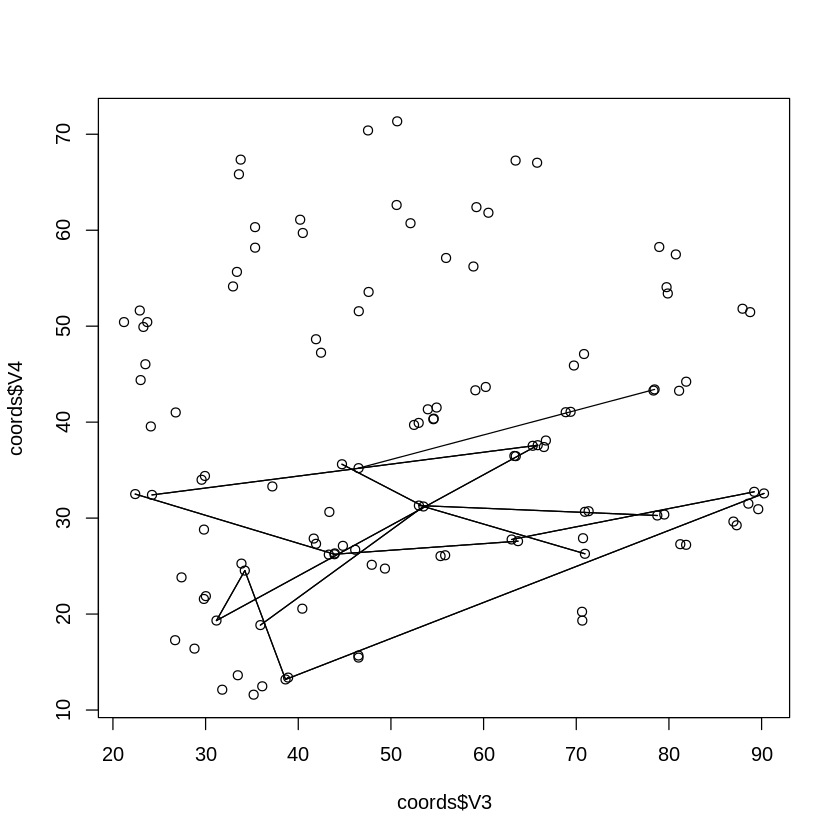

In [740]:
f1<- forest_objs[[CN_idx[6]]]
n<- f1$n

sum(f1$A_T[n+1,])

plot(coords$V3,coords$V4)
for(i in 2:n){
  for(j in 1:n){
    if(f1$A_T[i,j]==1){
        if(i %in% sel_node){
            if(j %in% sel_node){
                  lines(coords$V3[c(i,j)],coords$V4[c(i,j)])
        }
        }
    }
  }
}

[1] 4

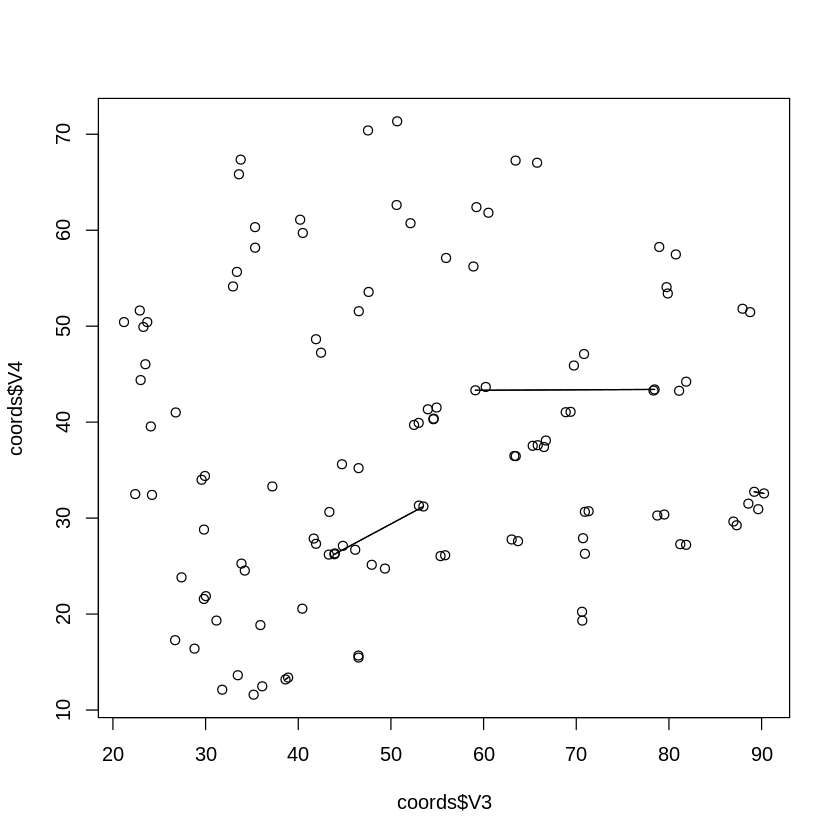

In [747]:
f1<- forest_objs[[LCMI_idx[1]]]
n<- f1$n

sum(f1$A_T[n+1,])

plot(coords$V3,coords$V4)
for(i in 2:n){
  for(j in 1:n){
    if(f1$A_T[i,j]==1){
        if(i %in% sel_node){
            if(j %in% sel_node){
                  lines(coords$V3[c(i,j)],coords$V4[c(i,j)])
        }
        }
    }
  }
}